In [54]:
# Importing packages
import cx_Oracle
import pandas as pd
from datetime import timedelta
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [55]:
# Variable declaration
a = timedelta(seconds=300)
month = str(1)      # Cast to string in order to use it in image titles (does not accept int types)
year = str(2021)    # Cast to string in order to use it in image titles (does not accept int types)
# Show all rows
#pd.set_option('display.max_rows', None)

In [56]:
# Importing data from Oracle database
con = cx_Oracle.connect('STC_SETRAG/art@localhost/XE')
cur = con.cursor()

# First Query
query=cur.execute('select * from historico_mensagens')
df = pd.DataFrame(query)
# Second Query
query=cur.execute('select EV_NOM_MAC from ELEM_VIA where TE_ID_TP = 3')
df_sb = pd.DataFrame(query)

cur.close()
con.close()

In [57]:
# Formatting dataframe

# Adding names to the columns of the dataframes
df.columns=['HM_ID_HM','HM_LOCO_MSG','HM_PRF_TRM','HM_OBC_MSG','HM_NUM_MSG','HM_TP_MSG','HM_DAT_OBC','HM_DAT_STC',
            'HM_TXT_MSG','HM_TXT_TW','HM_LAT_HM','HM_LON_HM','HM_ENV_RCB','HM_MSG_VOZ','HM_NUM_FUN','HM_ID_AUX','HM_SIT_ENV','MT_ID_MT']
df_sb.columns=['NAME']
# Dropping tables with no use
df = df.drop(['HM_TP_MSG','HM_TXT_TW','MT_ID_MT','HM_ID_AUX','HM_OBC_MSG','HM_LAT_HM','HM_LON_HM'], axis=1)

In [58]:
# Splitting dataframe in 'Sent' and 'Received' messages
df_sent = df.loc[df['HM_ENV_RCB']=='E']
df_received = df.loc[df['HM_ENV_RCB']=='R']

# Removing the original dataframe
df = pd.DataFrame(None)

In [59]:
# Filter Part I 

# Sent DataFrame
# 1) Filter messages from january 2021
df_sent = df_sent.loc[df_sent['HM_DAT_STC']>='2021-01-01']
df_sent = df_sent.loc[df_sent['HM_DAT_STC']<='2021-01-31']
# 2) Filter all messages that contain OBC time
df_sent = df_sent.loc[df_sent['HM_DAT_OBC'].notnull()]

# Received DataFrame
# 1) Filter all messages that did not expired
df_received = df_received.loc[df_received['HM_SIT_ENV']=='E']
# 2) Filter messages from january 2021
df_received = df_received.loc[df_received['HM_DAT_STC']>='2021-01-01']
df_received = df_received.loc[df_received['HM_DAT_STC']<='2021-01-31']
# 3) Filter all messages that contain OBC time
df_received = df_received.loc[df_received['HM_DAT_OBC'].notnull()]
# 4) Filter all messages that have a date later than needed (avoiding future date messages)
df_received = df_received.loc[df_received['HM_DAT_OBC']<'2021-02-02']

In [60]:
# Returns amount of messages after the first filtering
df_sent.shape, df_received.shape

((48685, 11), (72676, 11))

In [61]:
# Storing the total of messages in a variable after first filtering for both Sent and Received messages

# Sent
totalSentMessages = len(df_sent['HM_ID_HM'])

# Received
totalReceivedMessages = len(df_received['HM_ID_HM'])

# Total
totalMessages = totalSentMessages + totalReceivedMessages

totalSentMessages, totalReceivedMessages, totalMessages

(48685, 72676, 121361)

In [62]:
# Return the average delivery time of Sent and Received messages

# Sent
df_sent['DELIVERY_TIME'] = df_sent['HM_DAT_OBC']-df_sent['HM_DAT_STC']
# Converting to string in order to execute a mathematic operation
df_sent['DELIVERY_TIME'] = df_sent['DELIVERY_TIME']/np.timedelta64(1, 's')
totalSent = sum(df_sent.iloc[:,11])
averageSentDelivery = round(totalSent/totalSentMessages,0)
# Converting from float to mm:ss
averageSentDelivery = timedelta(seconds=averageSentDelivery)
averageSentDelivery=str(averageSentDelivery)

# Received
df_received['DELIVERY_TIME'] = df_received['HM_DAT_STC']-df_received['HM_DAT_OBC']
# Converting to string in order to execute a mathematic operation
df_received['DELIVERY_TIME'] = df_received['DELIVERY_TIME']/np.timedelta64(1, 's')
totalReceived = sum(df_received.iloc[:,11])
averageReceivedDelivery = round(totalReceived/totalReceivedMessages,0)
# Converting from float to mm:ss
averageReceivedDelivery = timedelta(seconds=averageReceivedDelivery)
averageReceivedDelivery = str(averageReceivedDelivery)

averageSentDelivery, averageReceivedDelivery

('0:03:10', '0:00:53')

In [63]:
# Return the average delivery time of Sent and Received messages combined
averageDelivery = round((totalSent + totalReceived)/(totalSentMessages + totalReceivedMessages),0)
# Converting from float to mm:ss
averageDelivery = timedelta(seconds=averageDelivery)
averageDelivery = str(averageDelivery)

averageDelivery

'0:01:48'

D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


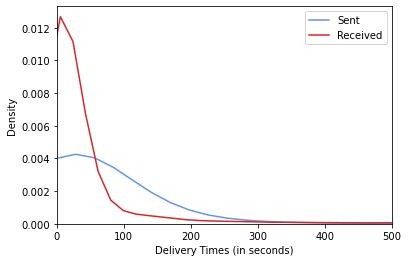

In [64]:
# Density graph
sns.distplot(df_sent['DELIVERY_TIME'],hist=False,kde=True,color = 'cornflowerblue', label = 'Sent')
sns.distplot(df_received['DELIVERY_TIME'],hist=False,kde=True, color = 'tab:red', label = 'Received')
plt.xlabel("Delivery Times (in seconds)") 
plt.legend(loc='best')
plt.xlim(0, 500)
plt.savefig('D:/app/kenne/product/18.0.0/admin/XE/images/density'+'_'+ month + '_' + year +'.png')
plt.show()

In [65]:
# Return % and total amount of messages that took more than 5min for both Sent and Received messages.

# Sent
totalSentDelay= df_sent.loc[(df_sent['HM_DAT_OBC']-df_sent['HM_DAT_STC']) >= a]
totalSentDelay = len(totalSentDelay)
averageSentDelay=(totalSentDelay/totalSentMessages)*100
averageSentDelay = round(averageSentDelay,2)
averageSentDelay = str(averageSentDelay)+ "%"

# Received
totalReceivedDelay= df_received.loc[(df_received['HM_DAT_STC']-df_received['HM_DAT_OBC']) >= a]
totalReceivedDelay = len(totalReceivedDelay)
averageReceivedDelay=(totalReceivedDelay/totalReceivedMessages)*100
averageReceivedDelay = round(averageReceivedDelay,2)
averageReceivedDelay = str(averageReceivedDelay)+ "%"

averageSentDelay, totalSentDelay, averageReceivedDelay, totalReceivedDelay

('7.1%', 3458, '3.31%', 2407)

In [66]:
# Return the total and % of messages that took more than 5 min with Sent and Received combined.
totalDelay = totalSentDelay + totalReceivedDelay
totalMessages = totalSentMessages + totalReceivedMessages
averageTotalDelay = (totalDelay/totalMessages)*100
averageTotalDelay = round(averageTotalDelay,2)
averageTotalDelay = str(averageTotalDelay)+"%"

averageTotalDelay, totalDelay

('4.83%', 5865)

In [67]:
## Time Series of the month

## Sent
## Adding a new column 'ADD' to dataframe to convert and slice the time from the date. 
#df_sent['DATE'] = df_sent.iloc[:,5]
#for i in range(0,len(df_sent['HM_ID_HM']),1):
#    df_sent.iloc[i,12] = str(df_sent.iloc[i,12]) # Converting to String
#    df_sent.iloc[i,12] = df_sent.iloc[i,12][:10] # Slicing - removing the time from the format
    
## Grouping number of messages per day
#ts_sent = df_sent.groupby(['DATE']).size()


## Received
## Adding a new column 'ADD' to dataframe to convert and slice the time from the date. 
#df_received['DATE'] = df_received.iloc[:,5]
#for i in range(0,len(df_received['HM_ID_HM']),1):
#    df_received.iloc[i,12] = str(df_received.iloc[i,12]) # Converting to String
#    df_received.iloc[i,12] = df_received.iloc[i,12][:10] # Slicing - removing the time from the format
    
## Grouping number of messages per day
#ts_received = df_received.groupby(['DATE']).size()

In [68]:
## Time series Graphs for Sent and received messages
## Sent
#plt.plot(ts_sent,color ='cornflowerblue', label='Sent')
#plt.xticks(rotation=90)
##for i in range(1000,max(ts_sent),200):
#    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
#plt.title("Delays per Day")

## Received
#plt.plot(ts_received,color ='tab:red', label='Received')
#plt.xticks(rotation=90)
##for i in range(1000,max(ts_sent),200):
##    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
#plt.title("Delays per Day")

#plt.legend(loc='best')
#plt.savefig('D:/app/kenne/product/18.0.0/admin/XE/images/time_series'+'_'+ month + '_' + year +'.png')

In [69]:
## Time Series TREND, SEASONAL and RANDOM for Sent and Received messages

## Creating the decomposition variable
#decomp_sent = seasonal_decompose(ts_sent, period=12) # Periods can be thought of as special cases of intervals
#decomp_received = seasonal_decompose(ts_received, period=12)

## Trend
#tend_sent = decomp_sent.trend
#tend_received = decomp_received.trend
## Seasonal
#seas_sent = decomp_sent.seasonal
#seas_received = decomp_received.seasonal
## Random
#rand_sent = decomp_sent.resid
#rand_received = decomp_received.resid

#plt.figure(1)
#plt.subplot(2,2,1)
#plt.plot(ts_sent,color ='cornflowerblue', label='Sent')
#plt.plot(ts_received,color ='tab:red',label='Received')
#plt.title('Time Series')
#plt.xticks([])
#plt.yticks([])
#plt.subplot(2,2,2)
#plt.plot(tend_sent,color ='cornflowerblue')
#plt.plot(tend_received,color ='tab:red')
#plt.xticks([])
#plt.yticks([])
#plt.title('Trend')
#plt.subplot(2,2,3)
#plt.plot(seas_sent,color ='cornflowerblue')
#plt.plot(seas_received,color ='tab:red')
#plt.xticks([])
##plt.yticks([])
#plt.title('Seasonality')
##plt.subplot(2,2,4)
##plt.plot(rand_sent,color ='cornflowerblue')
##plt.plot(rand_received,color ='tab:red')
##plt.xticks([])
##plt.yticks([])
##plt.title('Resid')
#plt.savefig('D:/app/kenne/product/18.0.0/admin/XE/images/time_series_decompose'+'_'+ month + '_' + year +'.png')

In [70]:
# Filter Part II

# Sent
# 3) Filter messages with macros 1001, 1002 and 1003
df_sent = df_sent.loc[(df_sent['HM_NUM_MSG']==1001)|(df_sent['HM_NUM_MSG']==1002)|(df_sent['HM_NUM_MSG']==1003)]
# 4) Filter messages that took longer than 5 minutes
df_sent = df_sent.loc[(df_sent['HM_DAT_OBC']-df_sent['HM_DAT_STC']) >= a]
# 5) Order the dataframe by HM_ID_HM
df_sent.sort_values(by=['HM_ID_HM'])

#Received
# 5) Filter messages with macros 2006, 2011, 2012, 2015, 2017, 2020, 2021 and 2029
df_received = df_received.loc[(df_received['HM_NUM_MSG']==2006)|(df_received['HM_NUM_MSG']==2011)|(df_received['HM_NUM_MSG']==2012)|(df_received['HM_NUM_MSG']==2015)|(df_received['HM_NUM_MSG']==2017)|(df_received['HM_NUM_MSG']==2020)|(df_received['HM_NUM_MSG']==2021)|(df_received['HM_NUM_MSG']==2029)]
# 6) Filter messages that took longer than 5 minutes
df_received = df_received.loc[(df_received['HM_DAT_STC']-df_received['HM_DAT_OBC']) >= a]
# 7) Order the dataframe by HM_ID_HM
df_received.sort_values(by=['HM_ID_HM'])
# 8) Remove messages that don't contain data
df_received = df_received.loc[df_received['HM_TXT_MSG'].notnull()]

df_sent.shape, df_received.shape

((198, 12), (935, 12))

In [71]:
# Store and return the amount of messages after filtering

# Sent
totalSentMessageDelay = len(df_sent['HM_ID_HM'])

# Received
totalReceivedMessageDelay = len(df_received['HM_ID_HM'])

totalSentMessageDelay, totalReceivedMessageDelay

(198, 935)

In [72]:
# Return the average delivery time of Sent and Received messages with delay (longer than 5 min.)

# Sent
df_sent['DELIVERY_TIME'] = df_sent['HM_DAT_OBC']-df_sent['HM_DAT_STC']
df_sent['DELIVERY_TIME'] = df_sent['DELIVERY_TIME']/np.timedelta64(1, 's')
Sent_Calc = sum(df_sent.iloc[:,11])
averageSentDeliveryDelay = round(Sent_Calc/totalSentMessageDelay,0)
# Converting from float to mm:ss
averageSentDeliveryDelay = timedelta(seconds=averageSentDeliveryDelay)
averageSentDeliveryDelay=str(averageSentDeliveryDelay)

# Received
df_received['DELIVERY_TIME'] = df_received['HM_DAT_STC']-df_received['HM_DAT_OBC']
df_received['DELIVERY_TIME'] = df_received['DELIVERY_TIME']/np.timedelta64(1, 's')
Received_Calc= sum(df_received.iloc[:,11])
averageReceivedDeliveryDelay = round(Received_Calc/totalReceivedMessageDelay,0)
# Converting from float to mm:ss
averageReceivedDeliveryDelay = timedelta(seconds=averageReceivedDeliveryDelay)
averageReceivedDeliveryDelay=str(averageReceivedDeliveryDelay)

averageSentDeliveryDelay, averageReceivedDeliveryDelay

('0:16:53', '0:13:24')

In [73]:
# Return the average delivery time of Sent and Received messages with delay (longer than 5 min.) combined
averageDeliveryDelay = round((Sent_Calc+Received_Calc)/(totalSentMessageDelay+totalReceivedMessageDelay),0)
# Converting from float to mm:ss
averageDeliveryDelay = timedelta(seconds=averageDeliveryDelay)
averageDeliveryDelay = str(averageDeliveryDelay)

averageDeliveryDelay

'0:14:00'

In [74]:
# Adding new columns to dataframe df_sb

for i in range(0,len(df_sb['NAME']),1):
    df_sb['SECTION_DEBUT'] = "Section Début: " + df_sb.loc[:,'NAME'] + " "
    df_sb['CANTON'] = "Canton: " + df_sb.loc[:,'NAME'] + " "
    df_sb['SECTION_TETE'] = "Section da Tête: " + df_sb.loc[:,'NAME'] + " "

df_sb['COUNTS_SENT'] = 0
df_sb['COUNTS_RECEIVED'] = 0
df_sb['COUNTS_TOTAL'] = 0
df_sb['TOTAL_TIME_SENT'] = 0.0
df_sb['TOTAL_TIME_RECEIVED'] = 0.0
df_sb['TOTAL_TIME'] = 0.0
df_sb['AVERAGE_TIME_SENT'] = 0.0
df_sb['AVERAGE_TIME_RECEIVED'] = 0.0
df_sb['AVERAGE_TIME'] = 0.0
df_sb['%_SENT'] = 0
df_sb['%_RECEIVED'] = 0
df_sb['%_TOTAL'] = 0

In [75]:
# Total of delays per SB and total delivery time per SB for Sent and Received messages

# Sent
for i in range(0,len(df_sb['NAME']),1):
    for j in range(0,totalSentMessageDelay,1):
        if df_sent.iloc[j,3] == 1002 and df_sb.iloc[i,1] in df_sent.iloc[j,6]:
            df_sb.iloc[i,4] += 1
            df_sb.iloc[i,7] += df_sent.iloc[j,11]

        if df_sent.iloc[j,3] != 1002 and df_sb.iloc[i,2] in df_sent.iloc[j,6]:
            df_sb.iloc[i,4] +=1
            df_sb.iloc[i,7] += df_sent.iloc[j,11]

# Received
for i in range(0,len(df_sb['NAME']),1):
    for j in range(0,totalReceivedMessageDelay,1):
        if df_sb.iloc[i,1] in df_received.iloc[j,6]:
            df_sb.iloc[i,5] += 1
            df_sb.iloc[i,8] += df_received.iloc[j,11]
            
        if df_sb.iloc[i,2] in df_received.iloc[j,6]:
            df_sb.iloc[i,5] += 1
            df_sb.iloc[i,8] += df_received.iloc[j,11]
            
        if df_sb.iloc[i,3] in df_received.iloc[j,6]:
            df_sb.iloc[i,5] += 1
            df_sb.iloc[i,8] += df_received.iloc[j,11]
            
# !! There may be a slight difference between totalReceivedMessageDelay and the sum of df_sb['COUNTS'].
# This is because the script does not consider messages on switches 
# There are also some messages that have 'Canton:' but don't contain an actual location !!

# Total
for i in range(0, len(df_sb['NAME']),1):
    df_sb.iloc[i,6] = df_sb.iloc[i,4] + df_sb.iloc[i,5]
    df_sb.iloc[i,9] = df_sb.iloc[i,7] + df_sb.iloc[i,8]

In [76]:
# Fix for Received Messages Count
x=0
for i in range(0,len(df_sb['NAME']),1):
    x = x + df_sb.iloc[i,5]
    
# A new value is returned to 'totalReceivedMessageDelay' to correctly count the % column.
# Please refer to the difference in the comments of the previous section. (Between '!!...!!')
totalReceivedMessageDelay = int(x)
totalReceivedMessageDelay

884

In [77]:
# Calculate the average delay per SB

# Sent
for i in range(0,len(df_sb['NAME']),1):
    if df_sb.iloc[i,4] != 0:
        df_sb.iloc[i,10] = df_sb.iloc[i,7]/df_sb.iloc[i,4]
        df_sb.iloc[i,10] = round(df_sb.iloc[i,10],0)    # Have to round the values to Integer to avoid having milliseconds
        df_sb.iloc[i,10] = str(timedelta(seconds=df_sb.iloc[i,10])) # Converting to String time format
        df_sb.iloc[i,7] = str(timedelta(seconds=df_sb.iloc[i,7]))
    else:
        df_sb.iloc[i,10] = 0      
        df_sb.iloc[i,10] = str(timedelta(seconds=df_sb.iloc[i,10]))
        df_sb.iloc[i,7] = str(timedelta(seconds=df_sb.iloc[i,7]))
        
# Received
for i in range(0,len(df_sb['NAME']),1):
    if df_sb.iloc[i,5] != 0:
        df_sb.iloc[i,11] = df_sb.iloc[i,8]/df_sb.iloc[i,5]
        df_sb.iloc[i,11] = round(df_sb.iloc[i,11],0)    # Have to round the values to Integer to avoid having milliseconds
        df_sb.iloc[i,11] = str(timedelta(seconds=df_sb.iloc[i,11])) # Converting to String time format
        df_sb.iloc[i,8] = str(timedelta(seconds=df_sb.iloc[i,8]))
    else:
        df_sb.iloc[i,11] = 0      
        df_sb.iloc[i,11] = str(timedelta(seconds=df_sb.iloc[i,11]))
        df_sb.iloc[i,8] = str(timedelta(seconds=df_sb.iloc[i,8]))
        
# Total
for i in range(0,len(df_sb['NAME']),1):
    if df_sb.iloc[i,6] != 0:
        df_sb.iloc[i,12] = df_sb.iloc[i,9]/df_sb.iloc[i,6]
        df_sb.iloc[i,12] = round(df_sb.iloc[i,12],0)    # Have to round the values to Integer to avoid having milliseconds
        df_sb.iloc[i,12] = str(timedelta(seconds=df_sb.iloc[i,12])) # Converting to String time format
        df_sb.iloc[i,9] = str(timedelta(seconds=df_sb.iloc[i,9]))
    else:
        df_sb.iloc[i,12] = 0      
        df_sb.iloc[i,12] = str(timedelta(seconds=df_sb.iloc[i,12]))
        df_sb.iloc[i,9] = str(timedelta(seconds=df_sb.iloc[i,9]))

In [78]:
# Calculate the % of total delays per SB

# Sent
for i in range(0,len(df_sb['NAME']),1):
    df_sb.iloc[i,13] = round((df_sb.iloc[i,4]/totalSentMessageDelay)*100,2)
    df_sb.iloc[i,13] = str(df_sb.iloc[i,13])+'%'
    
# Received
for i in range(0,len(df_sb['NAME']),1):
    df_sb.iloc[i,14] = round((df_sb.iloc[i,5]/totalReceivedMessageDelay)*100,2)
    df_sb.iloc[i,14] = str(df_sb.iloc[i,14])+'%'
    
# Total
for i in range(0,len(df_sb['NAME']),1):
    df_sb.iloc[i,15] = round((df_sb.iloc[i,6]/(totalSentMessageDelay+totalReceivedMessageDelay))*100,2)
    df_sb.iloc[i,15] = str(df_sb.iloc[i,15])+'%'

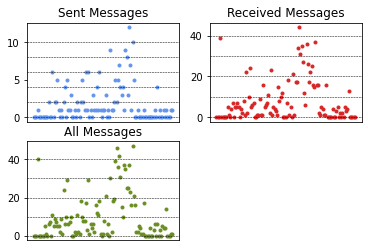

In [79]:
# Dispersion graph that represents all SBs em dots en shows the number of delays
plt.figure(1)
plt.subplot(2,2,1)
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,4], color='cornflowerblue', marker='.')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,4]),2):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.title("Sent Messages")
plt.subplot(2,2,2)
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,5], color='tab:red', marker='.')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,5]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.title("Received Messages") 
plt.subplot(2,2,3)
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,6], color='olivedrab', marker='.')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,6]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.title("All Messages")    
plt.savefig('D:/app/kenne/product/18.0.0/admin/XE/images/dispersion_all'+'_'+ month + '_' + year +'.png')

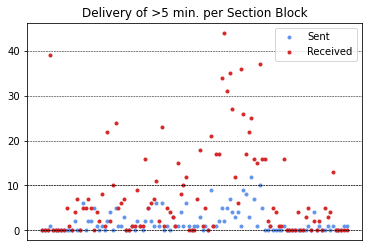

In [80]:
# Another dispersion graph, this time as one graph
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,4], color='cornflowerblue', marker='.', label='Sent')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,4]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
    
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,5], color='tab:red', marker='.', label='Received')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,5]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.legend(loc='best')
plt.title("Delivery of >5 min. per Section Block")
plt.savefig('D:/app/kenne/product/18.0.0/admin/XE/images/dispersion_sent_received'+'_'+ month + '_' + year +'.png')

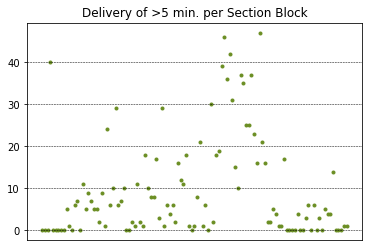

In [81]:
# Dispersion graph of SENT and RECEIVED messages (TOTAL) combined
plt.scatter(df_sb.iloc[:,0],df_sb.iloc[:,6], color='olivedrab', marker='.')
plt.xticks([])
for i in range(0,max(df_sb.iloc[:,6]),10):
    plt.axhline(y=i, color='black', linestyle='--',linewidth=0.5)
plt.title("Delivery of >5 min. per Section Block") 
plt.savefig('D:/app/kenne/product/18.0.0/admin/XE/images/dispersion_total'+'_'+ month + '_' + year +'.png')

In [82]:
# Reordering dataframe and selecting TOP 10 for barplot graph
ordered_Sent = df_sb.sort_values(by=['COUNTS_SENT'], ascending=False)
ordered_Received = df_sb.sort_values(by=['COUNTS_RECEIVED'], ascending=False)
ordered_Total = df_sb.sort_values(by=['COUNTS_TOTAL'], ascending=False)

top10_Sent = ordered_Sent.head(n=10)
top10_Received = ordered_Received.head(n=10)
top10_Total = ordered_Total.head(n=10)

top10_Sent = top10_Sent.sort_values(by=['COUNTS_SENT'], ascending=True)
top10_Received = top10_Received.sort_values(by=['COUNTS_RECEIVED'], ascending=True)
top10_Total = top10_Total.sort_values(by=['COUNTS_TOTAL'], ascending=True)

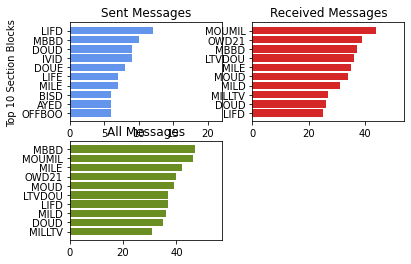

In [83]:
# Horizontal Barplot 
plt.figure(1)
plt.subplot(2,2,1)
plt.barh(top10_Sent.iloc[:,0],top10_Sent.iloc[:,4], color ='cornflowerblue',align='center')
plt.xlim(0,max(df_sb.iloc[:,4])+10)
plt.xlabel("Number of messages") 
plt.ylabel("Top 10 Section Blocks")
plt.title("Sent Messages") 
# Adding percentage values of '%' column to the bars
#for index, value in enumerate(top10_Sent.iloc[:,4]):
#    plt.text(value, index, str(top10_Sent.iloc[index,13]))
plt.subplot(2,2,2)
plt.barh(top10_Received.iloc[:,0],top10_Received.iloc[:,5], color ='tab:red',align='center')
plt.xlim(0,max(df_sb.iloc[:,5])+10)
plt.title("Received Messages")
plt.subplot(2,2,3)
plt.barh(top10_Total.iloc[:,0],top10_Total.iloc[:,6], color ='olivedrab',align='center')
plt.xlim(0,max(df_sb.iloc[:,6])+10)
plt.title("All Messages") 
plt.savefig('D:/app/kenne/product/18.0.0/admin/XE/images/bar_all'+'_'+ month + '_' + year +'.png')

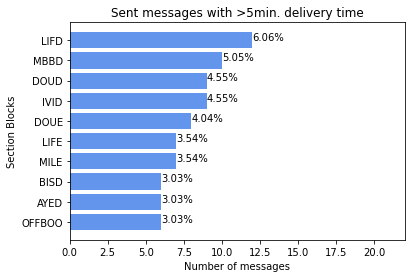

In [84]:
# Horizontal Barplot for Sent Messages
plt.barh(top10_Sent.iloc[:,0],top10_Sent.iloc[:,4], color ='cornflowerblue',align='center')
plt.xlim(0,max(df_sb.iloc[:,4])+10)
plt.xlabel("Number of messages") 
plt.ylabel("Section Blocks")
plt.title("Sent messages with >5min. delivery time") 
# Adding percentage values of '%' column to the bars
for index, value in enumerate(top10_Sent.iloc[:,4]):
    plt.text(value, index, str(top10_Sent.iloc[index,13]))
plt.savefig('D:/app/kenne/product/18.0.0/admin/XE/images/bar_sent'+'_'+ month + '_' + year +'.png')

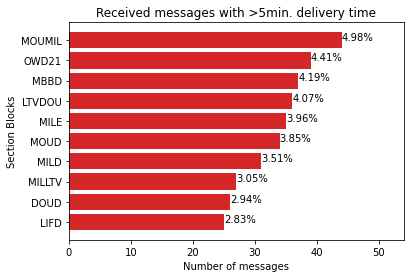

In [85]:
# Horizontal Barplot for Received Messages
plt.barh(top10_Received.iloc[:,0],top10_Received.iloc[:,5], color ='tab:red',align='center')
plt.xlim(0,max(df_sb.iloc[:,5])+10)
plt.xlabel("Number of messages") 
plt.ylabel("Section Blocks")
plt.title("Received messages with >5min. delivery time") 
# Adding percentage values of '%' column to the bars
for index, value in enumerate(top10_Received.iloc[:,5]):
    plt.text(value, index, str(top10_Received.iloc[index,14]))
plt.savefig('D:/app/kenne/product/18.0.0/admin/XE/images/bar_received'+'_'+ month + '_' + year +'.png')

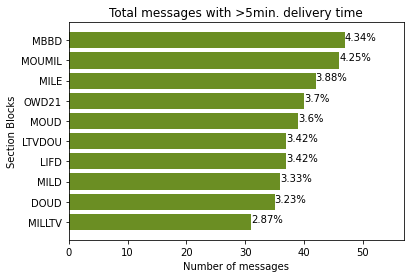

In [86]:
# Horizontal Barplot for Total Messages
plt.barh(top10_Total.iloc[:,0],top10_Total.iloc[:,6], color ='olivedrab',align='center')
plt.xlim(0,max(df_sb.iloc[:,6])+10)
plt.xlabel("Number of messages") 
plt.ylabel("Section Blocks")
plt.title("Total messages with >5min. delivery time") 
# Adding percentage values of '%' column to the bars
for index, value in enumerate(top10_Total.iloc[:,6]):
    plt.text(value, index, str(top10_Total.iloc[index,15]))
plt.savefig('D:/app/kenne/product/18.0.0/admin/XE/images/bar_total'+'_'+ month + '_' + year +'.png')

In [87]:
# Creating parameter values for import and Casting to Integers for Insert into database
density = 'density_'+month+'_'+year+'.png'
dispersion_all = 'dispersion_all_'+month+'_'+year+'.png'
dispersion_sent_received = 'dispersion_sent_received_'+month+'_'+year+'.png'
dispersion_total = 'dispersion_total_'+month+'_'+year+'.png'
bar_all = 'bar_all_'+month+'_'+year+'.png'
bar_sent = 'bar_sent_'+month+'_'+year+'.png'
bar_received = 'bar_received_'+month+'_'+year+'.png'
bar_total = 'bar_total_'+month+'_'+year+'.png'
#time_series = 'time_series_'+month+'_'+year+'.png' 
#time_series_decompose = 'time_series_decompose'+month+'_'+year+'.png' 

month = int(month)
year = int(year)

In [88]:
con = cx_Oracle.connect('DATA_ANALYSIS/art@localhost/XE')
cur = con.cursor()

cur.execute("insert into SENT (ID_SENT, MONTH, YEAR, TOTALSENTMESSAGES, AVERAGESENTDELIVERY, AVERAGESENTDELAY, TOTALSENTDELAY, TOTALSENTMESSAGEDELAY, averageSentDeliveryDelay, regtimestamp) values (SENT_ID_SEQ.NEXTVAL, :month, :year, :totalSentMessages, :averageSentDelivery, :averageSentDelay, :totalSentDelay, :totalSentMessageDelay, :averageSentDeliveryDelay, sysdate)", [month, year, totalSentMessages, averageSentDelivery, averageSentDelay, totalSentDelay, totalSentMessageDelay, averageSentDeliveryDelay])
cur.execute("insert into RECEIVED (ID_RECEIVED, MONTH, YEAR, TOTALRECEIVEDMESSAGES, AVERAGERECEIVEDDELIVERY, AVERAGERECEIVEDDELAY, TOTALRECEIVEDDELAY, TOTALRECEIVEDMESSAGEDELAY, averageReceivedDeliveryDelay, regtimestamp) values (RECEIVED_ID_SEQ.NEXTVAL, :month, :year, :totalReceivedMessages, :averageReceivedDelivery, :averageReceivedDelay, :totalReceivedDelay, :totalReceivedMessageDelay, :averageReceivedDeliveryDelay, sysdate)", [month, year, totalReceivedMessages, averageReceivedDelivery, averageReceivedDelay, totalReceivedDelay, totalReceivedMessageDelay, averageReceivedDeliveryDelay])
cur.execute("insert into TOTAL (ID_TOTAL, MONTH, YEAR, TOTALMESSAGES, AVERAGEDELIVERY, AVERAGETOTALDELAY, TOTALDELAY, averageDeliveryDelay, regtimestamp) values (TOTAL_ID_SEQ.NEXTVAL, :month, :year, :totalMessages, :averageDelivery, :averageTotalDelay, :totalDelay, :averageDeliveryDelay, sysdate)", [month, year, totalMessages, averageDelivery, averageTotalDelay, totalDelay, averageDeliveryDelay])
cur.execute("insert into GRAPHS (ID_GRAPHS, MONTH, YEAR, regtimestamp) values (GRAPHS_ID_SEQ.NEXTVAL, :month, :year, sysdate)", [month, year])
cur.callproc("graphs_pr",[month, year, density, dispersion_all, dispersion_sent_received, dispersion_total, bar_all, bar_sent, bar_received, bar_total])
con.commit()


cur.close()
con.close()